In [1]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from random import randint
import matplotlib.pyplot as plt
%matplotlib inline

## SR
from IPython.display import Image
from IPython.core.display import HTML 
from __future__ import print_function, division

In [2]:
mdata = pd.read_csv('data.csv') #Three stocks (R,X_s,X_b) Without predictors
mdata = np.array(mdata[['r','xs','xb']])

In [32]:
#hyperparams

num_epochs = 1000
series_length = 50
total_series_length = 241-series_length
batch_size = 5
truncated_backprop_length = series_length//batch_size
print(truncated_backprop_length)
state_size = 4
num_classes = 1
echo_step = 3
num_batches = total_series_length//batch_size//truncated_backprop_length
num_stocks = 3
print(total_series_length//batch_size)

10
38


In [4]:
# Reformat the data in such a way that the recurrent neural network can use it
# The dataset is nothing more than a mini batch of multiple time stamps
# The labels is the same time series shifted a few places (depending on the RNN)

def generateData():
    begin_idx = randint(0,total_series_length)
    x = mdata.transpose()
    x = x[0:3,begin_idx:begin_idx+series_length]
    #shift 3 steps to the left
    y = np.roll(x, echo_step, axis=1)
    #padd beginning 3 values with 0
    y[:,0:echo_step] = 0
    #Gives a new shape to an array without changing its data.
    #The reshaping takes the whole dataset and puts it into a matrix, 
    #that later will be sliced up into these mini-batches.
    x = x.reshape((num_stocks, batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((num_stocks, batch_size, -1))
    return (x, y)

data = generateData()

In [5]:
#TensorFlow works by first building up a computational graph, that 
#specifies what operations will be done. The input and output of this graph
#is typically multidimensional arrays, also known as tensors. 
#The graph, or parts of it can then be executed iteratively in a 
#session, this can either be done on the CPU, GPU or even a resource 
#on a remote server.

#operations and tensors

#The two basic TensorFlow data-structures that will be used in this 
#example are placeholders and variables. On each run the batch data 
#is fed to the placeholders, which are “starting nodes” of the 
#computational graph. Also the RNN-state is supplied in a placeholder, 
#which is saved from the output of the previous run.

#Step 2 - Build the Model

#datatype, shape (3,5,15) matrix, batch size shape for later
batchX_placeholder = tf.placeholder(tf.float32, [num_stocks, batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.float32, [ num_stocks, batch_size, truncated_backprop_length])

#and one for the RNN state, (3,5,4) 
init_state = tf.placeholder(tf.float32, [num_stocks, batch_size, state_size])

In [6]:
#The weights and biases of the network are declared as TensorFlow variables,
#which makes them persistent across runs and enables them to be updated
#incrementally for each batch.

#3 layer recurrent net, one hidden state

#randomly initialize weights
W = tf.Variable(np.random.rand(num_stocks, state_size+1, state_size), dtype=tf.float32)
#anchor, improves convergance, matrix of 0s 
b = tf.Variable(np.zeros((num_stocks,1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(num_stocks, state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((num_stocks, 1,num_classes)), dtype=tf.float32)

In [7]:
#Now it’s time to build the part of the graph that resembles the actual RNN computation, 
#first we want to split the batch data into adjacent time-steps.

# Unpack columns
#Unpacks the given dimension of a rank-R tensor into rank-(R-1) tensors.
#so a bunch of arrays, 1 batch per time step
inputs_series = tf.unstack(batchX_placeholder, axis=2)
labels_series = tf.unstack(batchY_placeholder, axis=2)


In [8]:
#Forward pass
#state placeholder
current_state = init_state
#series of states through time
states_series = []

#for each set of inputs
#forward pass through the network to get new state value
#store all states in memory
for current_input in inputs_series:
    #format input
    current_input = tf.reshape(current_input, [num_stocks,batch_size, 1])
    #mix both state and input data
    input_and_state_concatenated = tf.concat([current_input, current_state],axis=2)  # Increasing number of columns
    #perform matrix multiplication between weights and input, add bias
    #squash with a nonlinearity, for probabiolity value

    # perform matrix multiplication
    next_state = tf.tanh(tf.matmul(input_and_state_concatenated,W) + b)  # Broadcasted addition
    #store the state in memory
    states_series.append(next_state)
    #set current state to next one
    current_state = next_state


In [29]:
print(labels_series.shape)

AttributeError: 'list' object has no attribute 'shape'

In [31]:
#calculate loss
#second part of forward pass
#logits short for logistic transform
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
#apply softmax nonlinearity for output probability (No Softmax here because i want continuous output)
predictions_series = logits_series
print(len(predictions_series))

#measure loss, calculate softmax again on logits, then compute cross entropy
#measures the difference between two probability distributions
#this will return A Tensor of the same shape as labels and of the same type as logits 
#with the softmax cross entropy loss.
losses = [ abs(tf.reshape(logits,(num_stocks,-1)) - labels) for logits, labels in zip(logits_series,labels_series)]
# [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
#computes average, one value
# total_loss = np.mean(losses)
total_loss = tf.reduce_mean(tf.reduce_mean(losses))
#use adagrad to minimize with .3 learning rate
#minimize it with adagrad, not SGD
#One downside of SGD is that it is sensitive to
#the learning rate hyper-parameter. When the data are sparse and features have
#different frequencies, a single learning rate for every weight update can have
#exponential regret.
#Some features can be extremely useful and informative to an optimization problem but 
#they may not show up in most of the training instances or data. If, when they do show up, 
#they are weighted equally in terms of learning rate as a feature that has shown up hundreds 
#of times we are practically saying that the influence of such features means nothing in the 
#overall optimization. it's impact per step in the stochastic gradient descent will be so small 
#that it can practically be discounted). To counter this, AdaGrad makes it such that features 
#that are more sparse in the data have a higher learning rate which translates into a larger 
#update for that feature
#sparse features can be very useful.
#Each feature has a different learning rate which is adaptable. 
#gives voice to the little guy who matters a lot
#weights that receive high gradients will have their effective learning rate reduced, 
#while weights that receive small or infrequent updates will have their effective learning rate increased. 
#great paper http://seed.ucsd.edu/mediawiki/images/6/6a/Adagrad.pdf
train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

10


In [10]:
#visualizer
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

New data, epoch 0
New data, epoch 1
New data, epoch 2
New data, epoch 3
New data, epoch 4
New data, epoch 5
New data, epoch 6
New data, epoch 7
New data, epoch 8
New data, epoch 9
New data, epoch 10
New data, epoch 11
New data, epoch 12
New data, epoch 13
New data, epoch 14
New data, epoch 15
New data, epoch 16
New data, epoch 17
New data, epoch 18
New data, epoch 19
New data, epoch 20
New data, epoch 21
New data, epoch 22
New data, epoch 23
New data, epoch 24
New data, epoch 25
New data, epoch 26
New data, epoch 27
New data, epoch 28
New data, epoch 29
New data, epoch 30
New data, epoch 31
New data, epoch 32
New data, epoch 33
New data, epoch 34
New data, epoch 35
New data, epoch 36
New data, epoch 37
New data, epoch 38
New data, epoch 39
New data, epoch 40
New data, epoch 41
New data, epoch 42
New data, epoch 43
New data, epoch 44
New data, epoch 45
New data, epoch 46
New data, epoch 47
New data, epoch 48
New data, epoch 49
New data, epoch 50
New data, epoch 51
New data, epoch 52
New

New data, epoch 475
New data, epoch 476
New data, epoch 477
New data, epoch 478
New data, epoch 479
New data, epoch 480
New data, epoch 481
New data, epoch 482
New data, epoch 483
New data, epoch 484
New data, epoch 485
New data, epoch 486
New data, epoch 487
New data, epoch 488
New data, epoch 489
New data, epoch 490
New data, epoch 491
New data, epoch 492
New data, epoch 493
New data, epoch 494
New data, epoch 495
New data, epoch 496
New data, epoch 497
New data, epoch 498
New data, epoch 499
New data, epoch 500
New data, epoch 501
New data, epoch 502
New data, epoch 503
New data, epoch 504
New data, epoch 505
New data, epoch 506
New data, epoch 507
New data, epoch 508
New data, epoch 509
New data, epoch 510
New data, epoch 511
New data, epoch 512
New data, epoch 513
New data, epoch 514
New data, epoch 515
New data, epoch 516
New data, epoch 517
New data, epoch 518
New data, epoch 519
New data, epoch 520
New data, epoch 521
New data, epoch 522
New data, epoch 523
New data, epoch 524


New data, epoch 933
New data, epoch 934
New data, epoch 935
New data, epoch 936
New data, epoch 937
New data, epoch 938
New data, epoch 939
New data, epoch 940
New data, epoch 941
New data, epoch 942
New data, epoch 943
New data, epoch 944
New data, epoch 945
New data, epoch 946
New data, epoch 947
New data, epoch 948
New data, epoch 949
New data, epoch 950
New data, epoch 951
New data, epoch 952
New data, epoch 953
New data, epoch 954
New data, epoch 955
New data, epoch 956
New data, epoch 957
New data, epoch 958
New data, epoch 959
New data, epoch 960
New data, epoch 961
New data, epoch 962
New data, epoch 963
New data, epoch 964
New data, epoch 965
New data, epoch 966
New data, epoch 967
New data, epoch 968
New data, epoch 969
New data, epoch 970
New data, epoch 971
New data, epoch 972
New data, epoch 973
New data, epoch 974
New data, epoch 975
New data, epoch 976
New data, epoch 977
New data, epoch 978
New data, epoch 979
New data, epoch 980
New data, epoch 981
New data, epoch 982


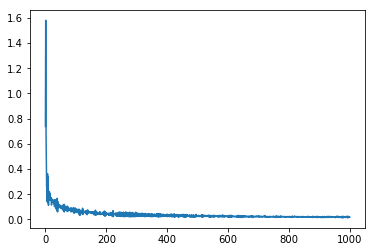

In [28]:
#Step 3 Training the network
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #interactive mode
    plt.ion()
    #initialize the figure
    plt.figure()
    #show the graph
    plt.show()
    #to show the loss decrease
    loss_list = []
    batch_idx = 0
    
    for epoch_idx in range(num_epochs):
        #generate data at every epoch, batches run in epochs
        x,y = generateData()
        #initialize an empty hidden state
        _current_state = np.zeros((num_stocks, batch_size, state_size))

        print("New data, epoch", epoch_idx)
        #each batch

        #starting and ending point per batch
        #since weights reoccuer at every layer through time
        #These layers will not be unrolled to the beginning of time, 
        #that would be too computationally expensive, and are therefore truncated 
        #at a limited number of time-steps
            
        batchX = x
        batchY = y
    
        # run the computation graph, give it the values
        # we calculated earlier
        _total_loss, _train_step, _current_state, _predictions_series = sess.run(
            [total_loss, train_step, current_state, predictions_series],
            feed_dict={
                batchX_placeholder:batchX,
                batchY_placeholder:batchY,
                init_state:_current_state
            })
        

        batch_idx += 1
        loss_list.append(_total_loss)
#         if batch_idx%10 == 0:
#             print("Step",batch_idx, "Loss", _total_loss)
#         plt.plot(loss_list, _predictions_series[0,:,:], batchX[1,:,:], batchY[1,:,:])

print(_predictions_series[-1])
print(batchY[:,:,9:10])
plt.plot(loss_list)
plt.ioff()
plt.show()


In [ ]:
# Build an reinforcement learning agent around the RNN




